# >> [LINK TO EXECUTIVE SUMMARY](#Executive-Summary) <<
<hr />

# Data science: Direct marketing optimization
### Task:
Use dummy data to maximize revenue from direct marketing campaigns.

### Data:
For the analysis, several tables are available.
* Social-demographical data (age, gender, tenure in a bank)
* Products owned + actual volumes (current account, saving account, mutual funds, overdraft, credit card, consumer loan)
* Inflow/outflow on C/A, aggregated card turnover (monthly average over past 3 months)
* For 60 % of clients actual sales + revenues from these are available (training set)

### Conditions:
The bank has capacity to contact only 15 pct. of the clients with a marketing offer and each client can be targeted only once.

### Proposed steps:
1. Create an analytical dataset (both training and test)
2. Develop 3 propensity models (consumer loan, credit card, mutual fund) using training data set
3. Optimize targeting clients with the direct marketing offer to maximize the revenue

### Expected result:
* Which clients have higher propensity to buy consumer loan?
* Which clients have higher propensity to buy credit card?
* Which clients have higher propensity to buy mutual fund?
* Which clients are to be targeted with which offer? General description.
* What would be the expected revenue based on your strategy?

The executive summary of the analysis should not be larger than two pages. Attach the technical report, list of clients to be contacted with which offer, data, algorithms and codes used.

# 0. Loading dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
RANDOM_STATE = 42

In [2]:
# Read in Excel file
dfs = pd.ExcelFile("./Data_science_Dataset.xlsx")
dfs.sheet_names

['Description',
 'Soc_Dem',
 'Products_ActBalance',
 'Inflow_Outflow',
 'Sales_Revenues']

In [3]:
df_Description = dfs.parse(dfs.sheet_names[0])

# to ensure the whole column string is displayed
with pd.option_context('display.max_colwidth', 800):
    display(df_Description)

,Sheet,Variable,Description
0,Soc_Dem,Client,client ID
1,NaN,Sex,gender
2,NaN,Age,age [years]
3,NaN,Tenure,tenure with the bank [months]
4,Products_ActBalance,Client,client ID
5,NaN,Count_CA,number of live current accounts
6,NaN,Count_SA,number of live saving accounts
7,NaN,Count_MF,number of live mutual funds
8,NaN,Count_OVD,number of live overdrafts
9,NaN,Count_CC,number of live credit cards


# 1. Data processing & Exploration

Before EDA (exploratory data analysis), check for missing and/or corrupted values.

Here we detect entries that do not make sense and deal with them, while trying to justify the reasoning.

In [4]:
# Since the task is client-centred, it makes sense to use the Client as the index
def indexWithClient(df):
    df.index = df.Client
    df = df.drop("Client", axis=1)
    return df.sort_index()

In [5]:
df_Soc_Dem = indexWithClient(dfs.parse(dfs.sheet_names[1]))              # "Soc_Dem" sheet
df_Products_ActBalance = indexWithClient(dfs.parse(dfs.sheet_names[2]))  # "Products_ActBalance" sheet
df_Inflow_Outflow = indexWithClient(dfs.parse(dfs.sheet_names[3]))       # "Inflow_Outflow" sheet
df_Sales_Revenues = indexWithClient(dfs.parse(dfs.sheet_names[4]))       # "Sales_Revenues" sheet

In [6]:
# Concatenate all the sheets into a single DataFrame
df = pd.concat([df_Soc_Dem, df_Products_ActBalance, df_Inflow_Outflow, df_Sales_Revenues], axis=1)
df.shape

(1615, 35)

In [7]:
# Get NaN counts
df.isna().sum()

Sex                                3
Age                                0
Tenure                             0
Count_CA                           0
Count_SA                        1189
Count_MF                        1309
Count_OVD                       1196
Count_CC                        1445
Count_CL                        1480
ActBal_CA                          0
ActBal_SA                       1189
ActBal_MF                       1309
ActBal_OVD                      1196
ActBal_CC                       1445
ActBal_CL                       1480
VolumeCred                        28
VolumeCred_CA                     28
TransactionsCred                  28
TransactionsCred_CA               28
VolumeDeb                         28
VolumeDeb_CA                      28
VolumeDebCash_Card                28
VolumeDebCashless_Card            28
VolumeDeb_PaymentOrder            28
TransactionsDeb                   28
TransactionsDeb_CA                28
TransactionsDebCash_Card          28
T

There are 3 NaNs in the 'Sex' field of the 'Soc_Dem' sheet. There are several ways to deal with this problem: For instance, one could try to estimate the value based on other instances with similarly-valued attributes, use mean/median (for numerical values), keep the data etc. However, given, that there are only 3 missing instances in the entire dataset of 1615 entries, we will simply ignore those clients.

In [8]:
df.dropna(subset=['Sex'], inplace=True)

# also replace the categorical M/F Sex indicator with a numerical value (F=0, M=1)
df["Sex"] = pd.Categorical(df["Sex"]).codes 

We can also see that there are clients that have NaN values for certain types of accounts (and corresponding balances are also NaN). This likely indicates that a client has no such account and therefore an assumption is made that such NaN account entries are assumed to be 0. Consequently, balances on the non-existing accounts will also be set to 0. Having said that, in certain scenarios it might be desirable to indicate the (lack of) presence of an account differently.

In [9]:
df.update(df[['Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL']].fillna(0))
df.update(df[['ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL']].fillna(0))

Similarly, if a client has no entries for transactions/volume of transactions over the last three months, the assumption is that no transactions have been made and therefore the NaN values will also be set to 0.

In [10]:
df.update(df[['VolumeCred', 'VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
              'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder']].fillna(0))
df.update(df[['TransactionsCred', 'TransactionsCred_CA', 'TransactionsDeb', 'TransactionsDeb_CA',
              'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']].fillna(0))

It also could be useful to check for duplicate entries in the dataset, as these would not provide additional knowledge for the models but might bias the results.

In [11]:
len(df[df.duplicated()])

0

No duplicates were found.

`Count_*` and `Transactions*` fields should only contain integer values. After verifying that this is true, they are casted from floating point variables to integers.

In [12]:
int_cols = ['Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL',
            'TransactionsCred', 'TransactionsCred_CA', 'TransactionsDeb', 'TransactionsDeb_CA',
            'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']

for col in int_cols:
    df[col] = df[col].astype('int64')

Let's explore the data now...

In [13]:
# show all columns
with pd.option_context('display.max_columns', None):
    display(df.describe())

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000
mean,0.531017,42.851737,101.408189,1.078784,0.307692,0.887717,0.259926,0.105459,0.099256,2438.101514,4016.339385,3894.767521,32.867560,37.047284,354.889372,1793.398291,1481.087660,5.450372,4.193548,1668.700012,1435.360060,253.704438,148.033282,703.702178,15.732630,13.359801,1.956576,5.151985,4.518610,0.199586,0.250259,0.298862,1.928997,2.718437,3.595933
std,0.499192,18.565762,64.903220,0.333328,0.567802,3.875201,0.438730,0.307239,0.361148,7078.342695,17925.062600,34900.056682,158.067054,191.040551,1680.235782,5823.775658,4629.225173,6.346161,4.936444,5148.006954,4252.121691,752.533315,309.867961,3191.368570,16.246964,12.989881,2.701468,8.347502,5.201611,0.399896,0.433386,0.457996,9.953503,17.711309,7.741740
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.479286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.000000,44.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.267589,0.000000,0.000000,0.000000,0.000000,0.000000,214.286071,192.168839,2.000000,2.000000,202.077143,188.879464,0.000000,0.000000,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,41.000000,97.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,461.399464,0.000000,0.000000,0.000000,0.000000,0.000000,638.849107,601.400714,3.000000,3.000000,641.064107,607.785714,71.428571,16.455357,170.553571,11.000000,10.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,57.000000,151.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2174.675893,0.009821,0.000000,0.000000,0.000000,0.000000,1406.314464,1288.184286,6.000000,4.000000,1386.116964,1305.245804,342.857143,174.108036,493.188571,22.000000,19.000000,3.000000,7.000000,7.000000,0.000000,0.500000,1.000000,0.000000,0.035714,4.625000
max,1.000000,97.000000,273.000000,4.000000,5.000000,79.000000,1.000000,1.000000,5.000000,171575.889643,389883.830714,761235.504286,2055.325357,3522.233571,20749.294643,107703.804286,98717.675000,63.000000,48.000000,119906.503929,73477.932500,23571.428571,3637.616786,72278.782143,102.000000,83.000000,25.000000,60.000000,34.000000,1.000000,1.000000,1.000000,220.488214,407.962500,133.275357


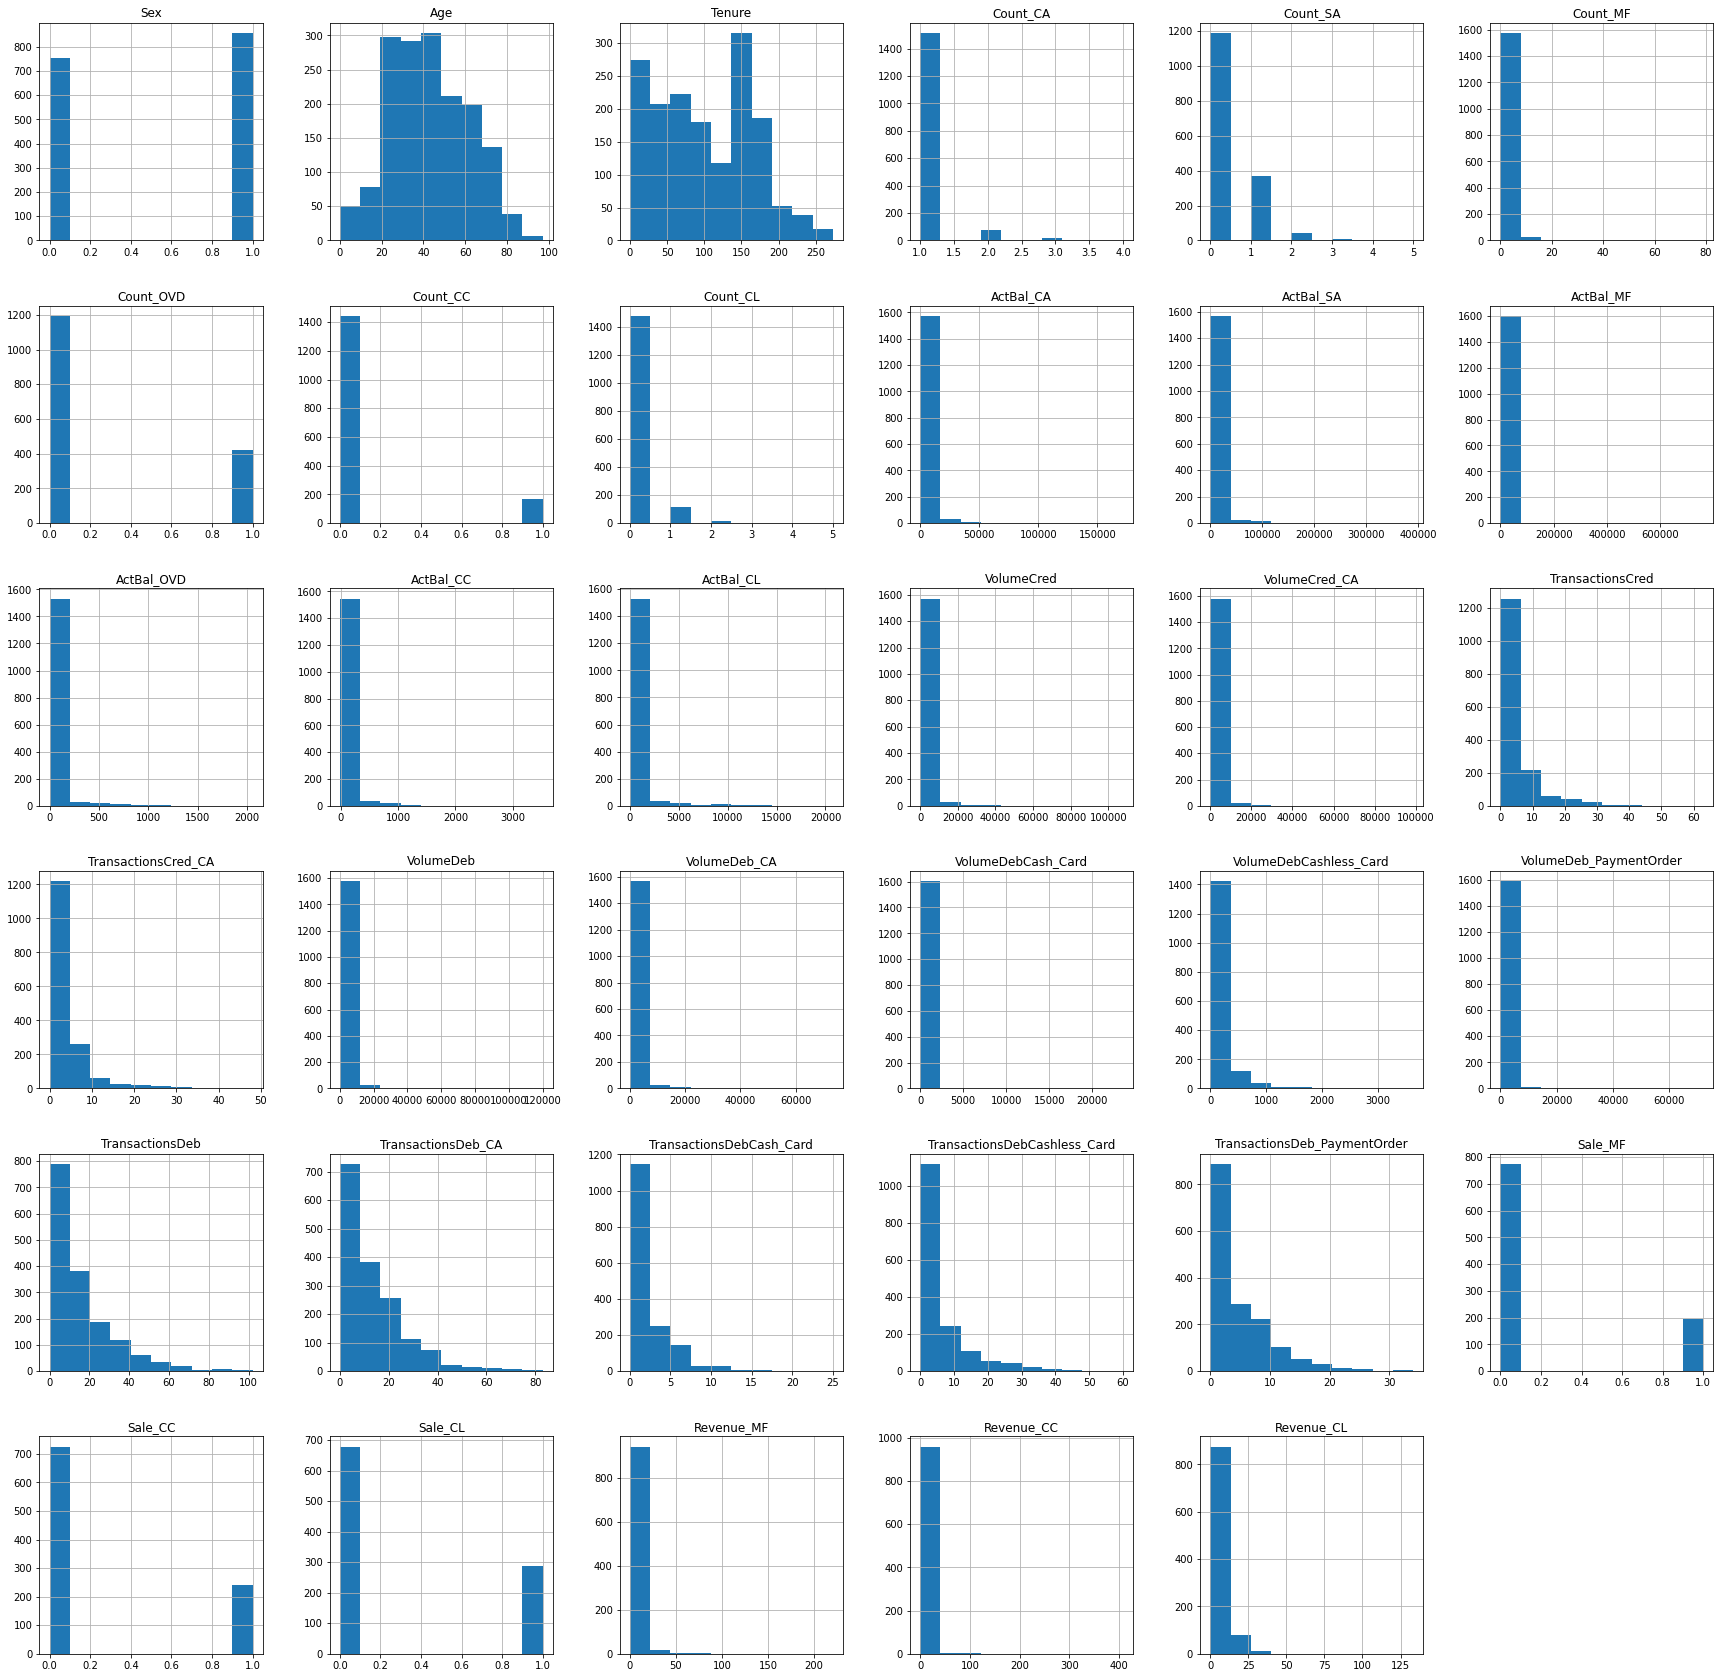

In [14]:
# Examine distribution of values of each attribute by placing them into bins:
df.hist(figsize=(30,30))
plt.show()   # added to suppress textual output by .hist()

First interesting observation - there appear to be some odd values for the 'Age' field of the account holders. Let's examine further..

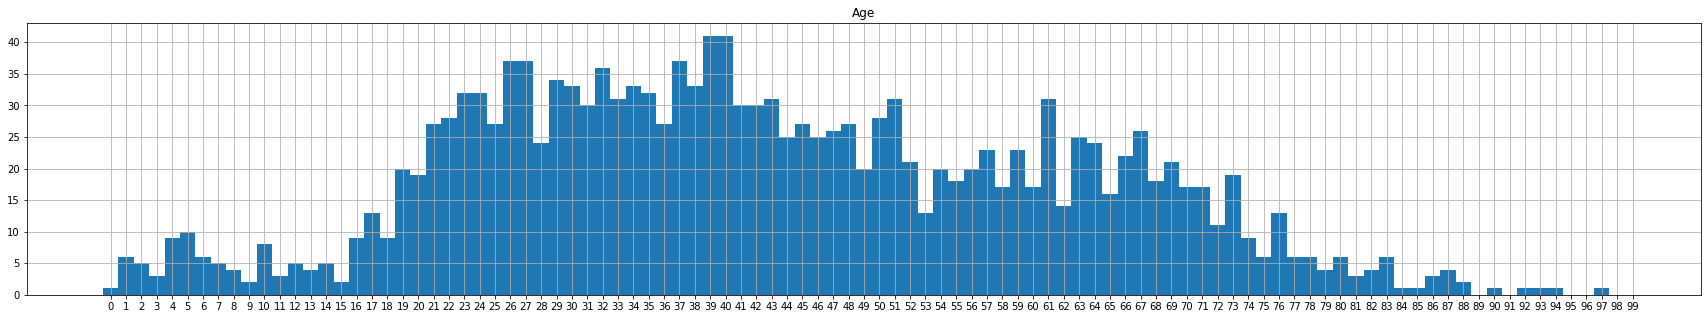

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
158,1,0,152,1,1,0,0,0,0,326.630357,...,13,0,13,0,0.0,0.0,0.0,0.0,0.000000,0.000000
316,0,1,211,1,0,0,0,0,0,22.733571,...,21,6,1,9,0.0,0.0,1.0,0.0,0.000000,15.015357
638,1,1,31,1,0,0,1,0,0,89.250000,...,9,1,4,1,0.0,0.0,0.0,0.0,0.000000,0.000000
391,1,1,16,1,0,0,0,1,1,172.581429,...,18,4,0,6,0.0,0.0,0.0,0.0,0.000000,0.000000
322,0,1,92,1,1,0,0,0,0,2175.270000,...,2,0,0,0,0.0,1.0,0.0,0.0,1.785714,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,1,17,27,1,1,1,0,0,0,156.846429,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
729,1,17,85,1,1,1,1,0,0,2082.308929,...,14,0,0,11,0.0,1.0,1.0,0.0,3.502143,28.148929
733,1,17,4,1,1,0,0,0,0,5.706786,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df[['Age']].hist(bins=np.arange(0, 100), figsize=(30,5),  align="left")
plt.xticks(np.arange(0, 100))
plt.show()

df[df['Age'] < 18].sort_values(by='Age')

This revealed an interesting issue: Some 6% of account holders are younger than 18 years of age. Theoretically, it is possible for an underage person to. However, the legal conditions limit the actions allowed and such accounts are in no way full personal accounts. 

For instance, accounts with mutual funds or overdrafts would not be possible. Debit cards cannot be issued until a child turns 8, transfers between accounts are not allowed until a child turns 15 and so on. Furthermore, the age of the account holder for some accounts seems to be less than the client's tenure with the bank:

In [16]:
with pd.option_context('display.max_rows', 10):
    display(df[df['Age'] < df['Tenure']//12].loc[:, 'Age':'Tenure'])

,Age,Tenure
Client,,
23,4,160
158,0,152
225,14,187
300,5,87
316,1,211
...,...,...
1561,12,204
1569,3,152
1583,8,151


As a result, it was assumed that entries below the age of 18 in this dataset are random errors in the clients' records. There are several days this can be dealt with:
* The entries can be deleted from the dataset entirely, as it can be argued the data points they contain might be flawed;
* The Age and/or Tenure fields might be cleared (changed to NaNs), and a model that can cope with NaNs well should then be chosen;
* The Age and/or Tenure fields can be recomputed: Use mean/median values, develop a separate model (e.g. MICE, kNN) that will use knowledge from the rest of the dataset to recompute the values with respect to other parameters and so on.

These options seem to grow more preferable with the size of the underlying dataset increasing. Should we be able to work with a large dataset, it can be argued that the bias of computing new values from other existing entries will be smaller and therefore the prediction quality of the model will be impacted to a lesser extent. Given that our dataset only contains some 1600 entries and for the sake of simplicity, the first approach was chosen. Entries for users below the age of 18 were removed, same for entries where age of the holder was less than their tenure with the bank.

In [17]:
df.drop(df[df.Age < 18].index, inplace=True)
df.drop(df[df['Age'] < df['Tenure']//12].index, inplace=True)

Finally, the remaining NaN values indicate that the particular client instances do not have actual sales + revenues associated with them. These are to be predicted. Entries with non-NaN values are part of the training set, while the remainder will be inputs to the models. Indeed, the instances with non-NaN fields make up 60% of the dataset, as mentioned in the task description.

In [18]:
null_mask = df['Sale_MF'].isnull()
df_train = df[~null_mask]
df_guess = df[null_mask]
# sanity check that the split was right
assert(df_train.shape[0] + df_guess.shape[0] == df.shape[0])
# drop empty columns (values to be predicted)
df_guess = df_guess.drop(columns=['Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC', 'Revenue_CL'])

# 2. Modelling

The task is to develop propensity models (consumer loan, credit card, mutual fund), i.e.:
1. Predict which customers will purchase consumer loan + expected revenue;
2. Predict which customers will purchase credit card + expected revenue;
3. Predict which customers will purchase mutual fund + expected revenue.

The bank only has the capacity to contact 15% of the clients with a marketing offer and each client can be targeted only once. Therefore, we want to determine which clients should be targeted with which offer in order to maximize the revenue.

## 2.1 Consumer Loan Data

Let's begin by exploring data related to **consumer loans**. The task of predicting which customer will purchase consumer loans is an example of classification. Plotting the distribution of attribute values with respect to the target class might help revealing some information on what to expect.

### 2.1.1 Consumer Loan Sale

In [19]:
# Plotting function that visualises difference among attribute values in binary classification tasks
def compare_binary_class_difference(class_name):
    classes = sorted(df_train[class_name].unique())
    
    plt.figure(figsize=(30,25))
    # Iterate through all attributes
    for i, col in enumerate(df_train.columns):
        # Skip the output classes for this evaluation predict (i.e. `y`)
        if "Sale_" in col or "Revenue_" in col:
            continue
        plt.subplot(6, 5, i+1)
        plt.hist([df_train.loc[df_train[class_name] == x, col] for x in classes],
                 label=classes)
        plt.legend([class_name + "=0", class_name + "=1"])
        plt.title(col)
    plt.show()

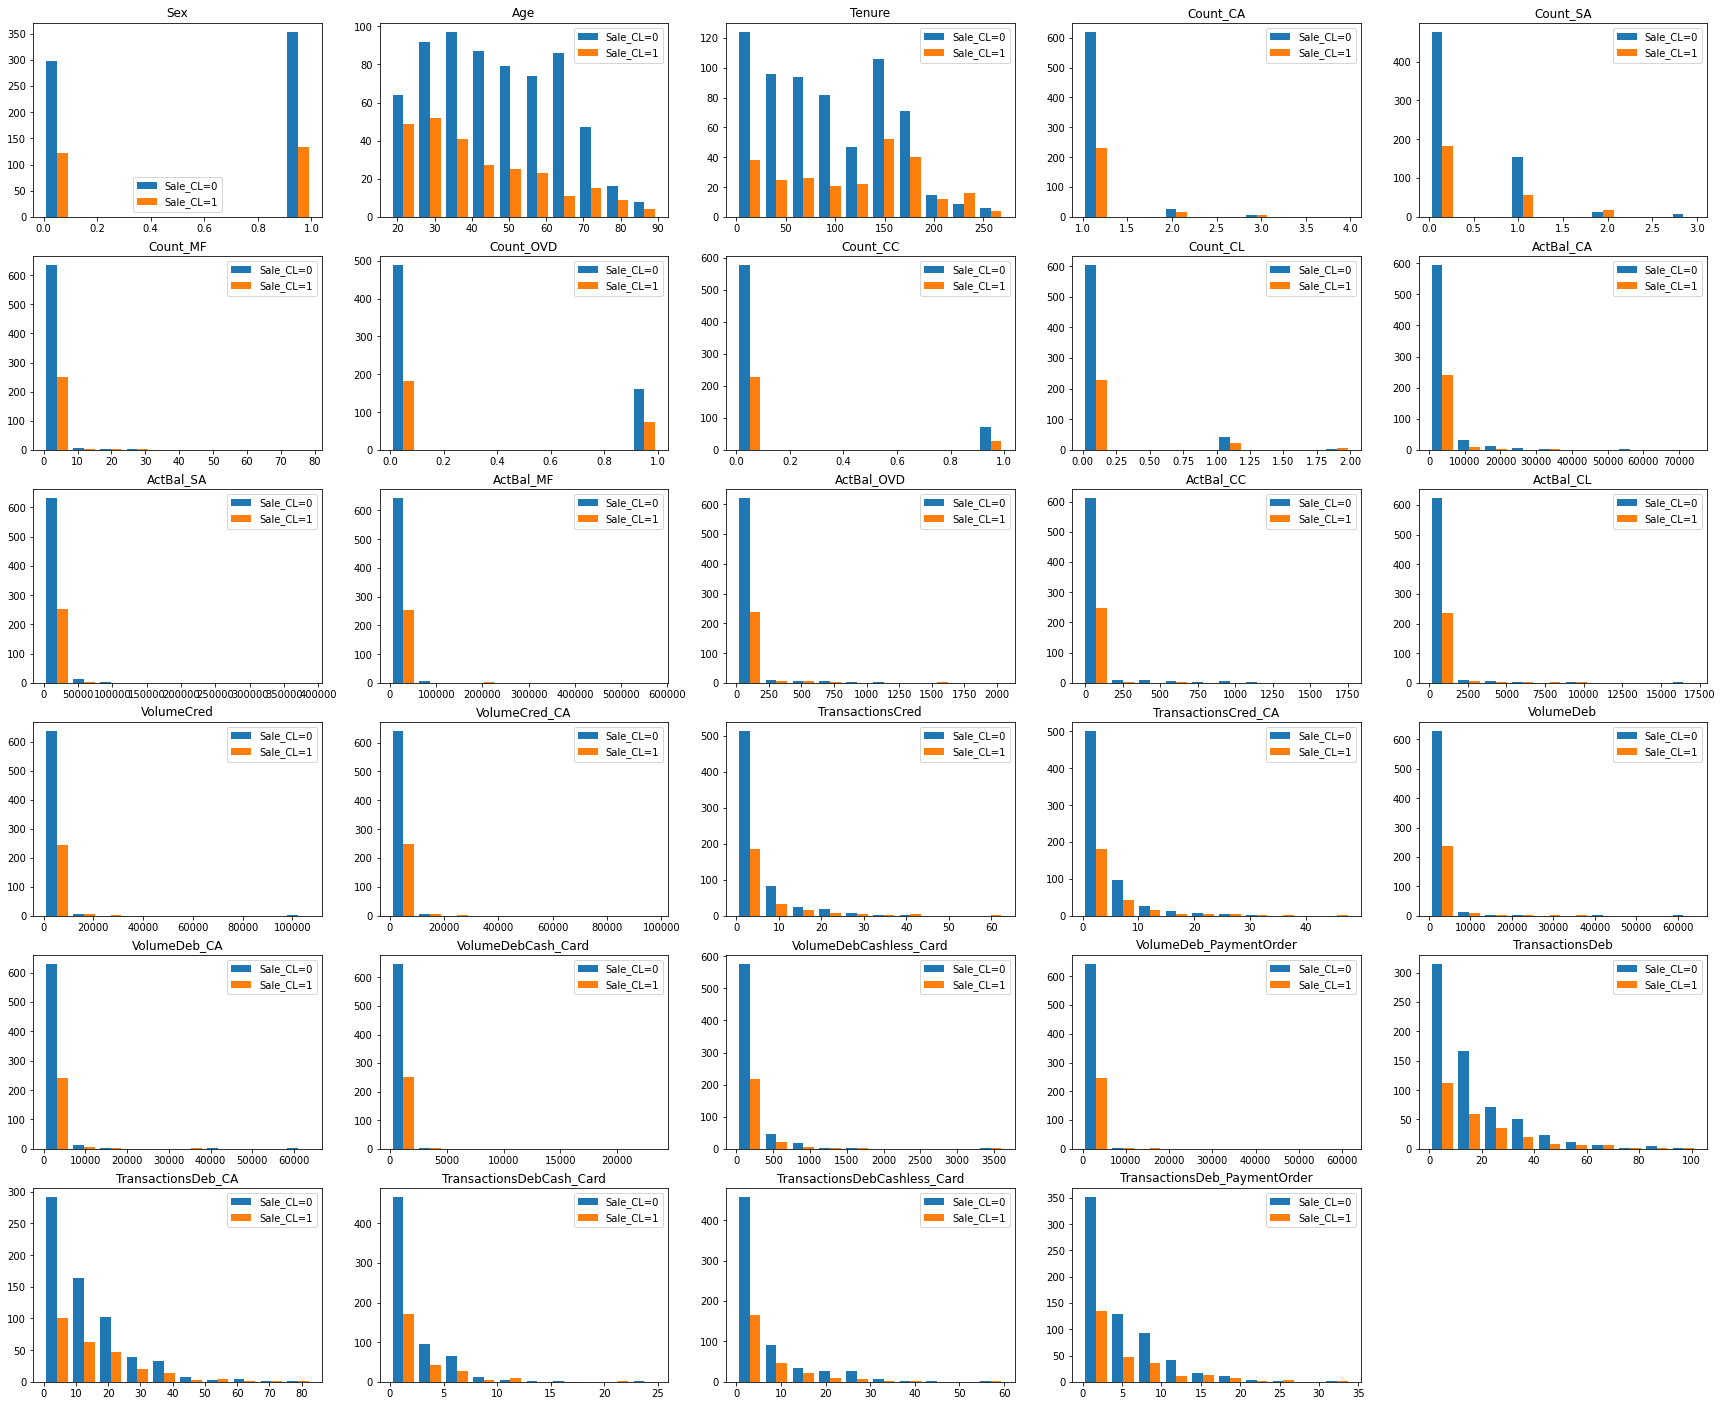

In [20]:
compare_binary_class_difference('Sale_CL')

There are some interesting trends we can observe. Among other things, consumer loans seem to be more popular among both young and old ends of the age spectrum. Similarly, they also seem to be popular with clients that have been with the bank for a while. Also, clients with a larger monthly volume of debit transactions via payment order tend to have a consumer loan.

When choosing the features for the model to learn from, it might be sensible to leave out some *independent variables* whose was value might have been affected by what we are trying to predict. In case of consumer loan sale, the value of `Count_CL`, and `ActBal_CL`  might have been affected by dependent variable `Sale_CL`/`Revenue_CL`. As a result, these features will be left out. (It might be also valid to consider the same for `TransactionsCred` and `VolumeCred`, but it is unclear from the description of the variables whether this should be done.)

**However for complex models, it might be useful to think more in depth about what features to keep in, based on additional data available to the bank. Perhaps people that already have had a loan and successfully paid it in full might be more inclined to have another loan. Similarly, from the perspective of the bank, a client with other active loans might be penalised in bank's scoring algorithm as being more a more 'risky' choice for a consumer loan offer due to the increased possibility of becoming insolvent.**

In [21]:
features_CL = ['Sex', 'Age', 'Tenure',
               'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC',
               'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC',
               'VolumeCred', 'VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
               'TransactionsCred', 'TransactionsCred_CA', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']
df_train_CL_X = df_train[features_CL]
df_train_Sale_CL_Y = df_train[['Sale_CL']].to_numpy().flatten()
df_train_Revenue_CL_Y = df_train[['Revenue_CL']].to_numpy().flatten()

To encapsulate those and other trends in the data, let's build a model. To begin with, random forests seem to be a good choice as they can be applied to both classification and regression tasks (later) and are wildly used. They do not require data normalization, so we can dive right in.

In [22]:
def train_classification_model(df_X, df_Y, **hyperparams):
    X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y,
                                                        test_size=0.2,
                                                        random_state=RANDOM_STATE)
    
    # because the classes are imbalanced, we need to compute class weights
    class_weights = compute_class_weight('balanced', classes=[0, 1], y=Y_train)

    clf = RandomForestClassifier(**hyperparams,
                                 class_weight={c: class_weights[c] for c in [0,1]},
                                 random_state=RANDOM_STATE)
    clf.fit(X_train, Y_train)
    
    Y_pred_test = clf.predict_proba(X_test)[:, 1]
    Y_pred_train = clf.predict_proba(X_train)[:, 1]

    print('Training set metrics:')
    print('Accuracy: ', accuracy_score(Y_train, np.round(Y_pred_train)))
    print('Precision:', precision_score(Y_train, np.round(Y_pred_train)))
    print('Recall:   ', recall_score(Y_train, np.round(Y_pred_train)))
    print('AUC:      ', roc_auc_score(Y_train, Y_pred_train))
    print("-----------------------------")
    print('Test set metrics:')
    print('Accuracy: ', accuracy_score(Y_test, np.round(Y_pred_test)))
    print('Precision:', precision_score(Y_test, np.round(Y_pred_test)))
    print('Recall:   ', recall_score(Y_test, np.round(Y_pred_test)))
    print('AUC:      ', roc_auc_score(Y_test, Y_pred_test))
    
    return clf

As with any machine learning model, there are some key steps that should be addressed to produce quality results. Tuning hyperparameters is key to increase performance of a model. For the models used here a grid search approach was used. Since the output data in the dataset is imbalanced, we try to compensate by penalizing instances of the more prevalent class.

When evaluating the results, the quality should be validated on an unseen test dataset to help increase generalization of the model. This is also true when picking proper evaluation metrics. Here, they are *accuracy* (what percentage of predictions were correct), the balance between *precision* (what the model predicted correctly over what the model predicted) and *recall* (what the model predicted correctly over what the true labels are), and *area under curve* (measure of separability between positive and negative instances).

In [23]:
m_Sale_CL = train_classification_model(df_train_CL_X, df_train_Sale_CL_Y,
                                       criterion='entropy',
                                       n_estimators=50,
                                       min_samples_split=100,
                                       min_samples_leaf=5,)

Training set metrics:
Accuracy:  0.8066298342541437
Precision: 0.6380090497737556
Recall:    0.7014925373134329
AUC:       0.8555121143802975
-----------------------------
Test set metrics:
Accuracy:  0.7142857142857143
Precision: 0.5294117647058824
Recall:    0.4909090909090909
AUC:       0.6989262705798138


The trained consumer loan sale model is slightly overfit, but offering results good enough to proceed further for our purposes. Further research into other models, their structure, and attributes could potentially lead to even better results.


Given the random-guessing baseline (i.e. 50% accuracy score), the model offers a significant improvement for correctly classifying the target from the inputs.

The importance of each attribute is also evaluated to give more insight into how the model interprets the underlying dataset. This procedure breaks the relationship between the feature and the target. It is obtained by evaluating the decrease in a model score when a single feature value is randomly shuffled.

In [24]:
def visualize_permutation_importance(m, df_X, df_Y):
    result = permutation_importance(m,
                                    df_X, df_Y,
                                    n_repeats=10, n_jobs=2,
                                    random_state=RANDOM_STATE)
    
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T,
               labels=df_X.columns[sorted_idx],
                vert=False)
    ax.set_title("Permutation Importances")
    fig.tight_layout()
    plt.show()
    
    return sorted_idx

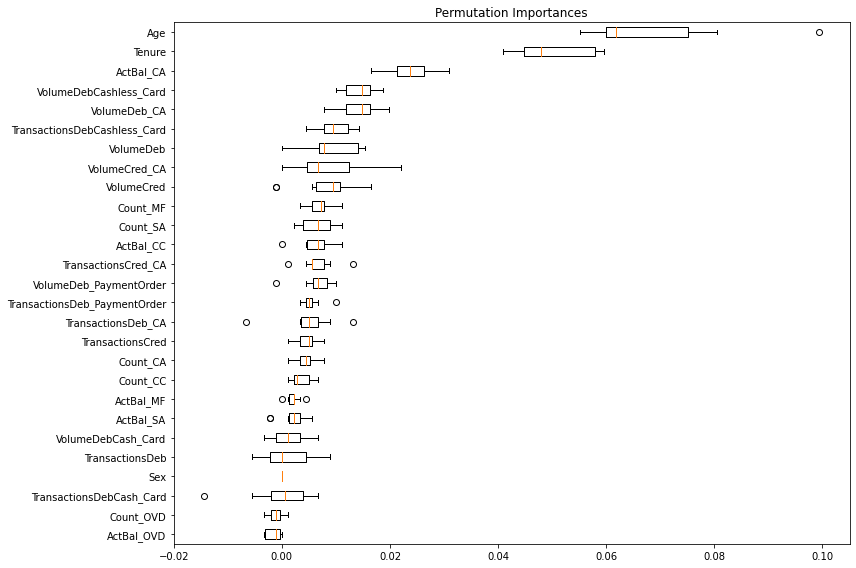

In [25]:
feature_importance_Sale_CL = visualize_permutation_importance(m_Sale_CL, df_train_CL_X, df_train_Sale_CL_Y)

The output clearly shows that the most important features of the consumer loan sale model were age and tenure of the client, followed by current account balance and several other features.

Exploiting partial dependence plots can be another powerful tool to gain insight from a predictive model. We can interpret the graphs as showing the expected target response as a function of the target features. While PDPs assume that the target features are independent from the complement features (often not true in practice), many trends in how the feature values' change affect the classifier's response can be seen.

Only the 8 most important features identified by the permutation importance algorithm are shown.

In [26]:
def visualize_partial_dependence(m, df_X, sorted_idx, threshold=8):
    fig, ax = plt.subplots(figsize=(30, 5))
    ax.set_title("%d most important features" % threshold)
    plot_partial_dependence(m, df_X,
                            df_X.columns[sorted_idx][::-1][:threshold],
                            n_cols=threshold,
                            n_jobs=-1,
                            grid_resolution=100, ax=ax)

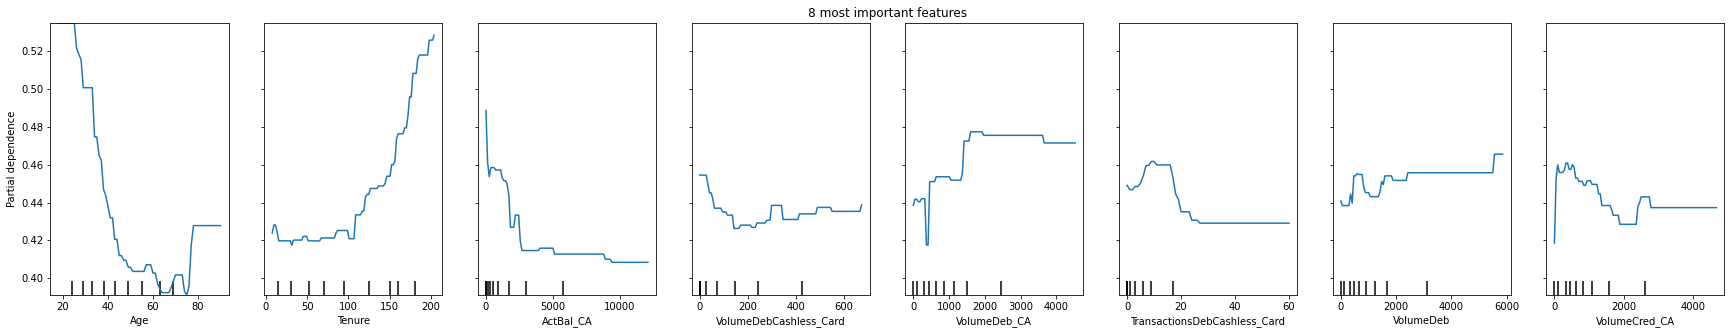

In [27]:
visualize_partial_dependence(m_Sale_CL, df_train_CL_X, feature_importance_Sale_CL)

At first glance, we can see how clients at either end of the age spectrum have the tendency to be favoured by the model for consumer loan sale. This is also true for clients with longer tenure at the bank. Both of these trends confirm the expectations of the data examination at the beginning of this section.

**When predicting the propensity to buy consumer loans, the most important features identified were `Age`, `Tenure`, `ActBal_CA` (current account balance), `VolumeDebCashless_Card` (monthly volume of debit cashless transactions via card), and `VolumeDeb_CA` (monthly debit turnover on current accounts).**

**Clients likely to purchase a consumer loan are either young clients of the bank, or retired clients that have been loyal customers. Their current and savings account balances are low, they have the tendency to use small cashless transactions and have a high turnover on their current accounts.**

### 2.1.2 Consumer Loan Revenue

Similar process has been adopted for developing the revenue model for the consumer loan offers. Unlike with the sale model, which was a classification task, the revenue model is a regression task. Despite implementing Random Forests as well, the model is trained differently.

In [28]:
def train_regression_model(df_X, df_Y, **hyperparams):
    X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y,
                                                        test_size=0.2,
                                                        random_state=RANDOM_STATE)
    reg = RandomForestRegressor(**hyperparams,
                                random_state=RANDOM_STATE)
    reg.fit(X_train, Y_train)
    
    Y_pred_train = reg.predict(X_train)
    Y_pred_test = reg.predict(X_test)
    print('RMSE (Training set): %0.3f' % mean_squared_error(Y_pred_train, Y_train, squared=False))
    print('RMSE (Test set):     %0.3f\n' % mean_squared_error(Y_pred_test, Y_test, squared=False))
    
    return reg

The most important thing to notice here is the way the model performance is evaluated. Here, the *root-mean-square error* value is calculated between the true and predicted value.

RMSE is the square root of the average of squared errors. The effect of each error on the overall value is proportional to the size of the squared error. Therefore, larger errors have a disproportionately large effect on RMSE.

In [29]:
m_Revenue_CL = train_regression_model(df_train_CL_X, df_train_Revenue_CL_Y,
                                      n_estimators=100,
                                      criterion='mse',
                                      max_depth=20,
                                      min_samples_split=10,
                                      min_samples_leaf=1)

RMSE (Training set): 3.732
RMSE (Test set):     11.308



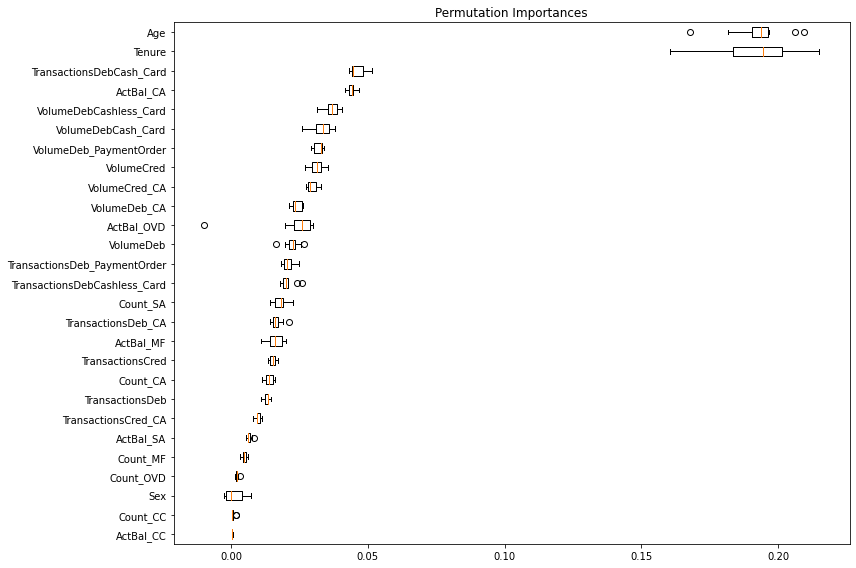

In [30]:
feature_importance_Revenue_CL = visualize_permutation_importance(m_Revenue_CL, df_train_CL_X, df_train_Revenue_CL_Y)

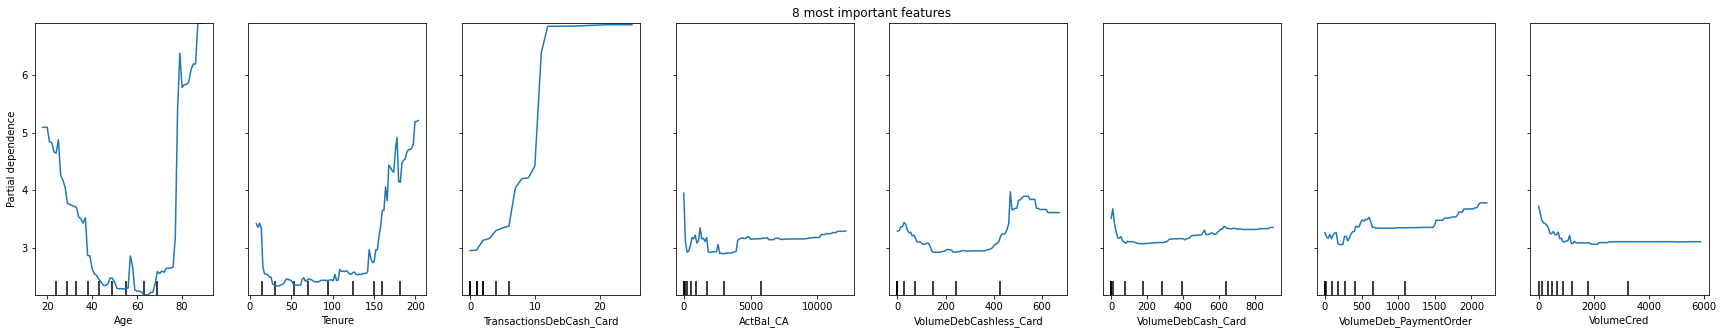

In [31]:
visualize_partial_dependence(m_Revenue_CL, df_train_CL_X, feature_importance_Revenue_CL)

While some of the trends in the value remain similar to the previous model (which is to be expected), differences can be observed: For instance in the eyes of the model, larger number of monthly debit transactions via card seems to impact the size of the revenue from that client.

**The key features of profitable clients for consumer loans identified were `Age`, `Tenure`, `TransactionsDebCash_Card` (monthly number of debit cash transactions via card) `ActBal_CA`, and `VolumeDebCashless_Card`.**

**Profitable clients for consumer loan are similarly either young clients of the bank, or retired clients that have been loyal customers. Their current and savings account balance is low, they have the tendency to make more debit cash transactions. Profitable clients have more money in their current accounts and have a large volume of cashless card transactions.**

*The process of obtaining and evaluating the remaining models is analogous to sections [2.1.1](###2.1.1-Consumer-Loan-Sale) and [2.1.2](###2.1.2-Consumer-Loan-Revenue) and is therefore left without inline comments. The concrete observations can be found at the end of each section, and in the [executive summary](#Executive-Summary).*

## 2.2 Credit Card Data

### 2.2.1 Credit Card Sale

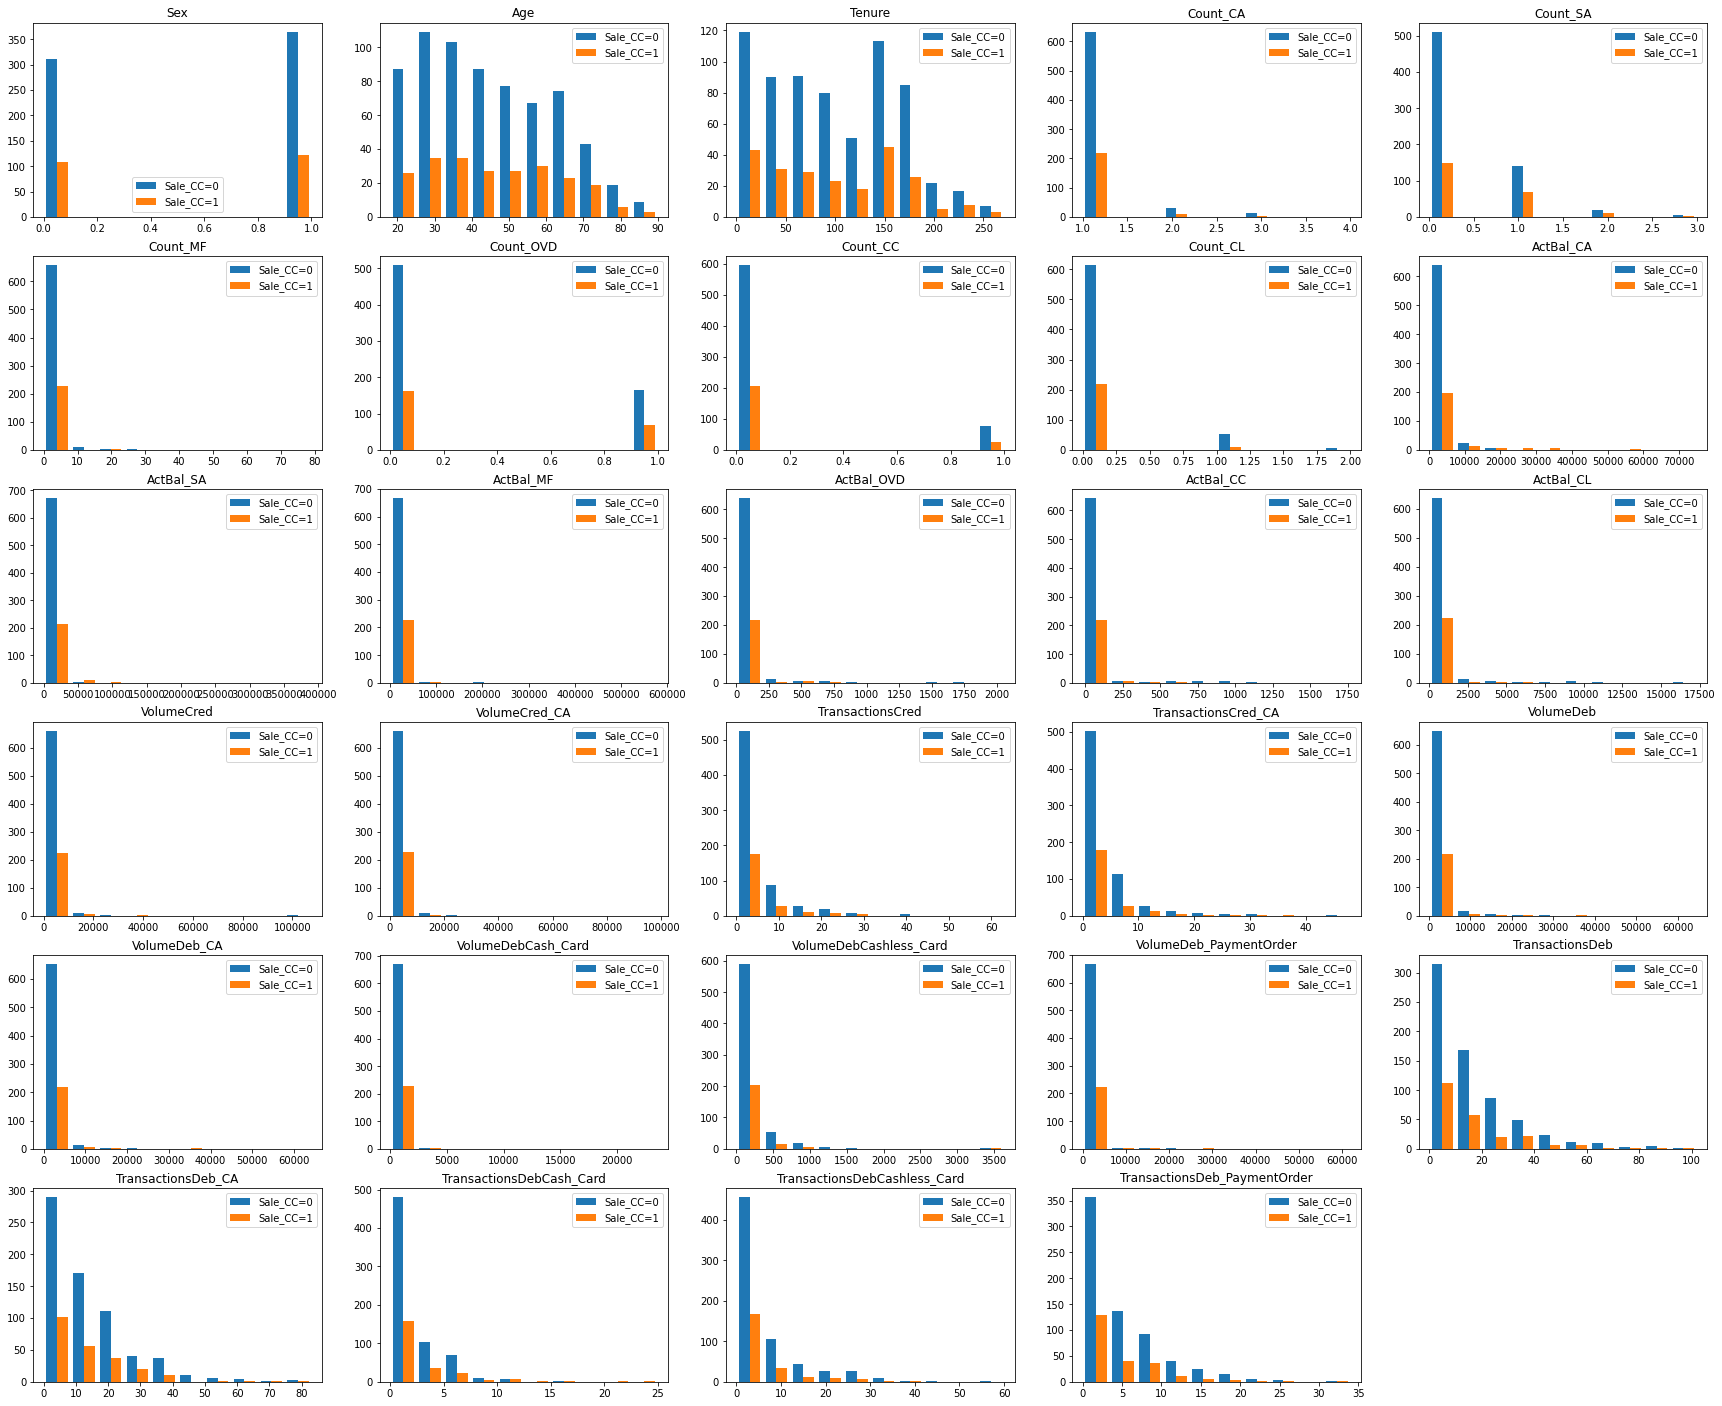

In [32]:
compare_binary_class_difference('Sale_CC')

In [33]:
features_CC = ['Sex', 'Age', 'Tenure',
               'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CL',
               'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CL',
               'VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
               'TransactionsCred_CA', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']
df_train_CC_X = df_train[features_CC]
df_train_Sale_CC_Y = df_train[['Sale_CC']].to_numpy().flatten()
df_train_Revenue_CC_Y = df_train[['Revenue_CC']].to_numpy().flatten()

In [34]:
m_Sale_CC = train_classification_model(df_train_CC_X, df_train_Sale_CC_Y,
                                       criterion='entropy',
                                       n_estimators=50,
                                       min_samples_split=50,
                                       min_samples_leaf=3)

Training set metrics:
Accuracy:  0.8950276243093923
Precision: 0.7951807228915663
Recall:    0.7586206896551724
AUC:       0.950700104493208
-----------------------------
Test set metrics:
Accuracy:  0.7307692307692307
Precision: 0.6428571428571429
Recall:    0.3157894736842105
AUC:       0.6314385964912281


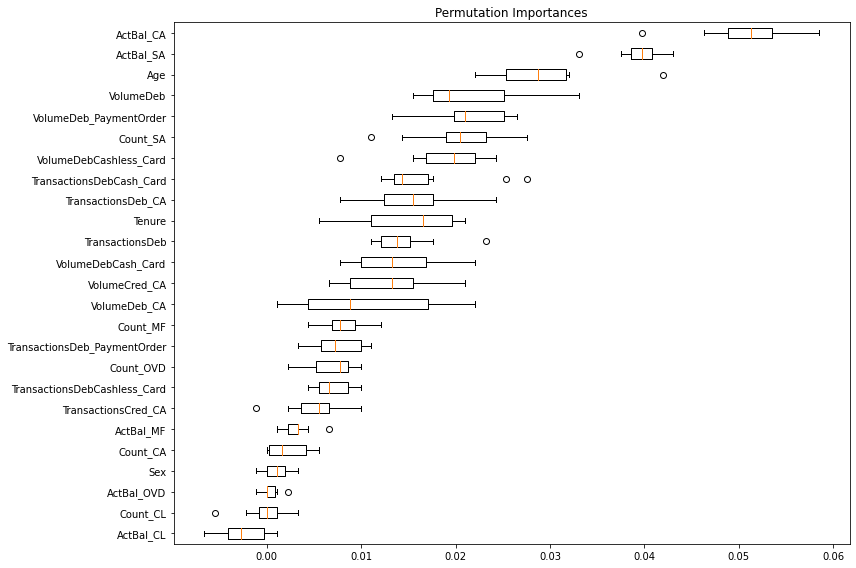

In [35]:
feature_importance_Sale_CC = visualize_permutation_importance(m_Sale_CC, df_train_CC_X, df_train_Sale_CC_Y)

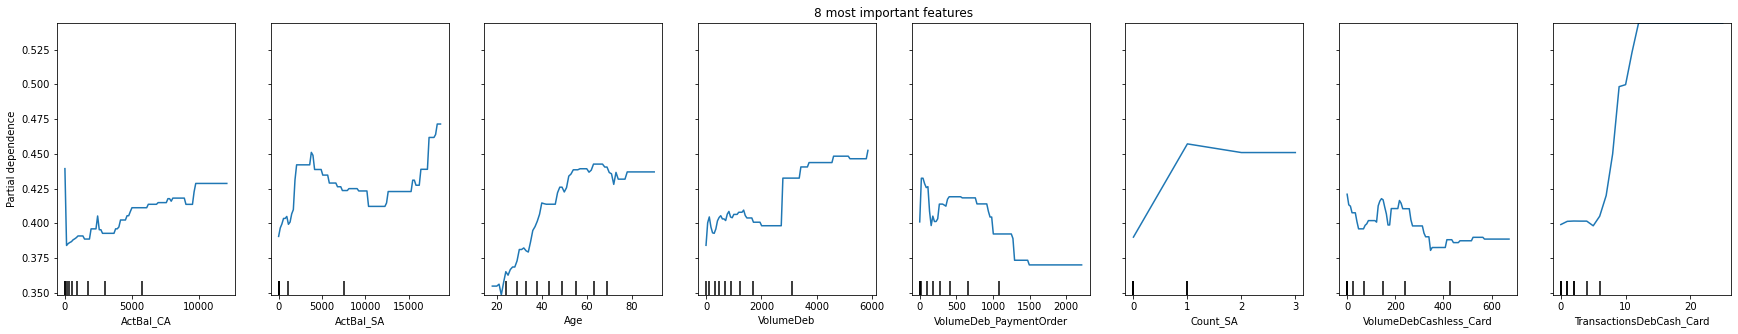

In [36]:
visualize_partial_dependence(m_Sale_CC, df_train_CC_X, feature_importance_Sale_CC)

**When predicting the propensity to purchase credit cards, the most important features identified were `ActBal_CA`, `ActBal_SA`, `Age`, `VolumeDeb` (monthly debit turnover), `VolumeDebPaymentOrder` (monthly volume of debit transactions via payment order), and `Count_SA`.**

**Clients likely to obtain a credit card are older clients of the bank with more than 2500EUR in their current account. Often, they have a savings account, with clients having over 15000EUR in it being more likely to purchase a card. In terms of turnovers, customers likely to obtain a credit card have a high debit turnover (over 3000EUR) turnover and generally make a smaller debit transactions via payment order.**

### 2.2.2 Credit Card Revenue

In [37]:
m_Revenue_CC = train_regression_model(df_train_CC_X, df_train_Revenue_CC_Y,
                                      n_estimators=1000,
                                      criterion='mse',
                                      max_depth=20,
                                      min_samples_split=5,
                                      min_samples_leaf=5)

RMSE (Training set): 11.525
RMSE (Test set):     31.863



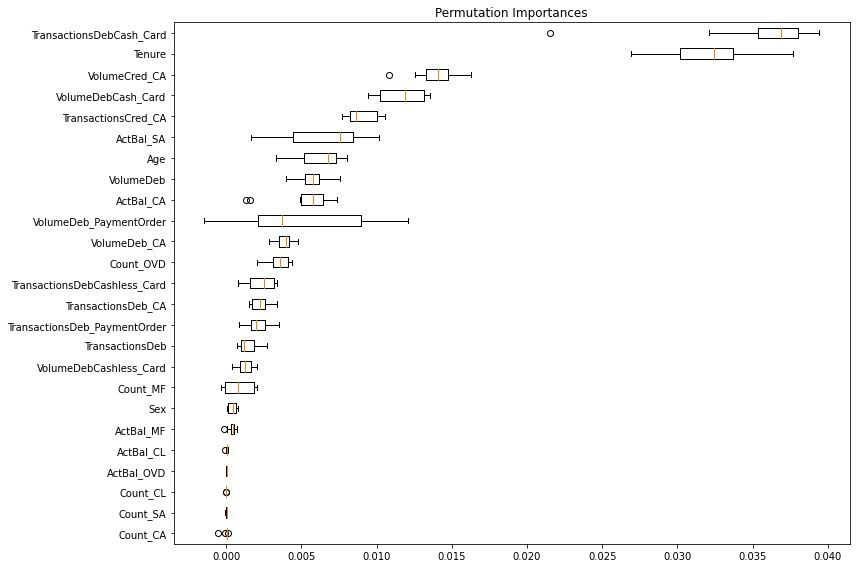

In [38]:
feature_importance_Revenue_CC = visualize_permutation_importance(m_Revenue_CC, df_train_CC_X, df_train_Revenue_CC_Y)

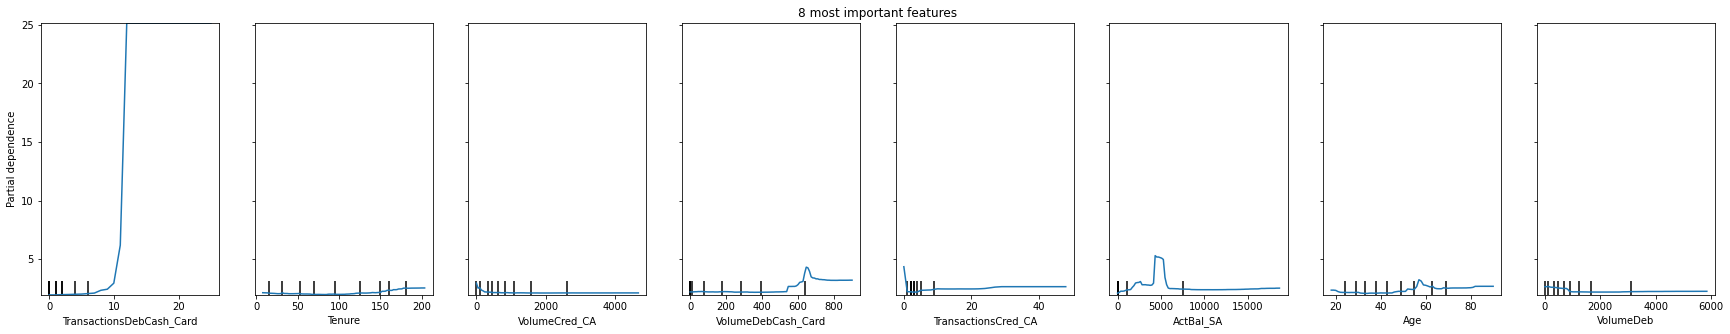

In [39]:
visualize_partial_dependence(m_Revenue_CC, df_train_CC_X, feature_importance_Revenue_CC)

**The key features of profitable clients of credit cards identified were `TransactionsDebCash_Card` (monthly number of debit cash transactions via card), `Tenure`, `VolumeCred_CA` (monthly credit turnover on current accounts), and `VolumeDebCash_Card` (monthly volume of debit cash transactions via card).**

**Profitable clients for credit card purchase tend to be clients with high amount of debit cash transactions via card that have been with the bank for a while. They are more likely to have a smaller credit turnover on their current accounts, but a larger volume of debit cash transactions.**

## 2.3 Mutual Fund Data

### 2.3.1 Mutual Fund Sale

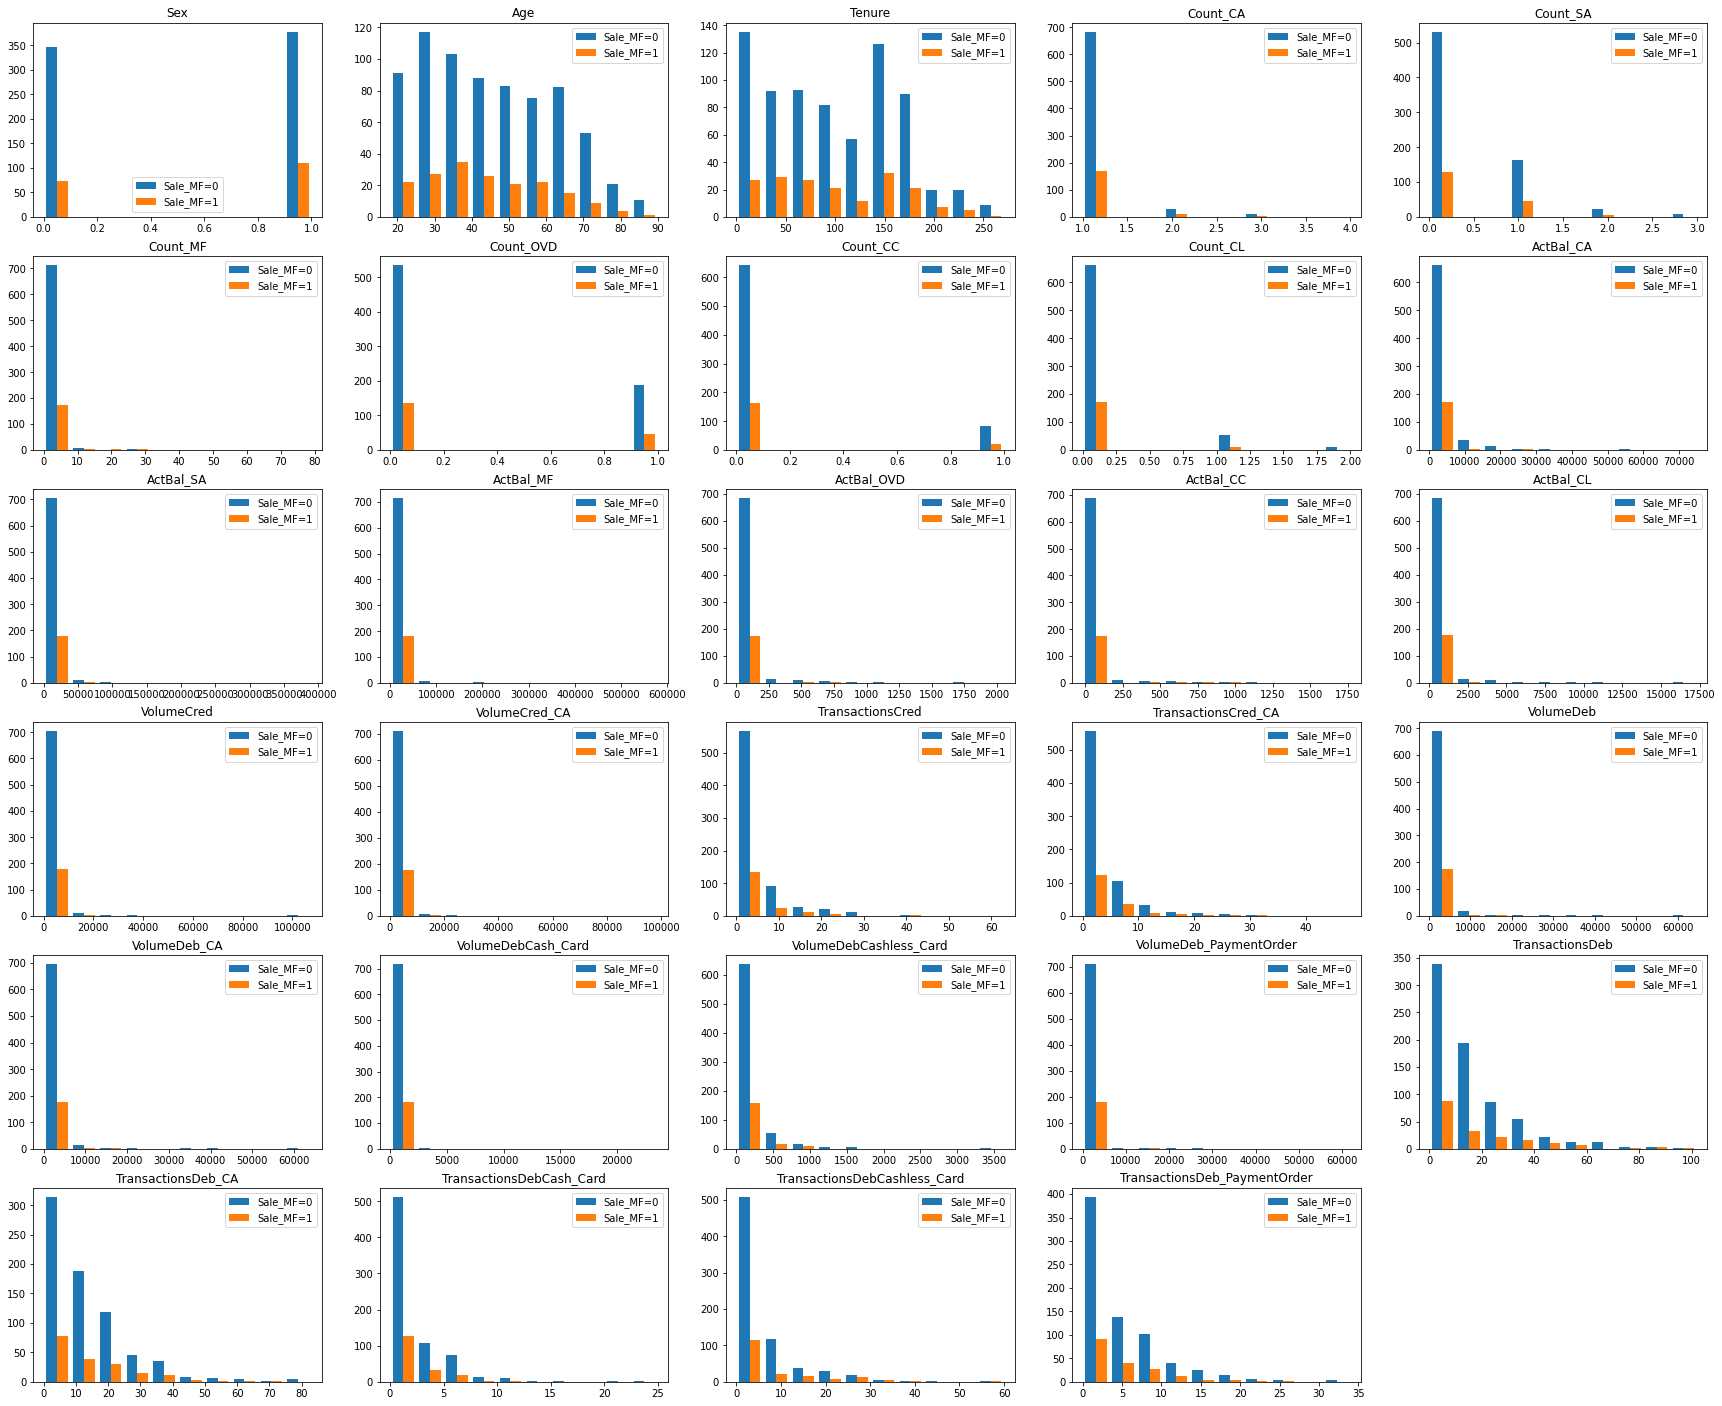

In [40]:
compare_binary_class_difference('Sale_MF')

In [41]:
features_MF = ['Sex', 'Age', 'Tenure',
               'Count_CA', 'Count_SA', 'Count_CL', 'Count_OVD', 'Count_CC',
               'ActBal_CA', 'ActBal_SA', 'ActBal_CL', 'ActBal_OVD', 'ActBal_CC',
               'VolumeCred', 'VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder',
               'TransactionsCred', 'TransactionsCred_CA', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']
df_train_MF_X = df_train[features_MF]
df_train_Sale_MF_Y = df_train[['Sale_MF']].to_numpy().flatten()
df_train_Revenue_MF_Y = df_train[['Revenue_MF']].to_numpy().flatten()

In [42]:
m_Sale_MF = train_classification_model(df_train_MF_X, df_train_Sale_MF_Y,
                                       criterion='entropy',
                                       n_estimators=45,
                                       min_samples_split=50,
                                       min_samples_leaf=10)

Training set metrics:
Accuracy:  0.8950276243093923
Precision: 0.7446808510638298
Recall:    0.7241379310344828
AUC:       0.9398606396283723
-----------------------------
Test set metrics:
Accuracy:  0.7582417582417582
Precision: 0.36
Recall:    0.24324324324324326
AUC:       0.6445479962721342


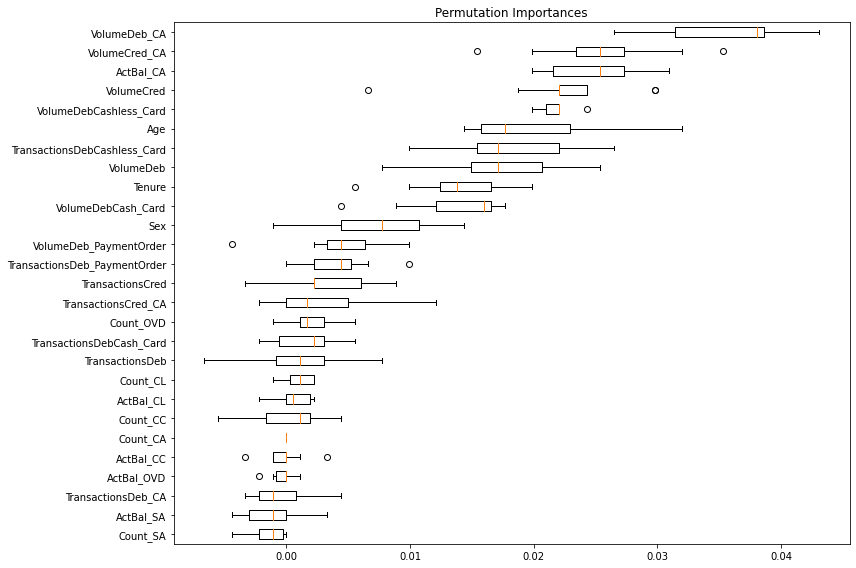

In [43]:
feature_importance_Sale_MF = visualize_permutation_importance(m_Sale_MF, df_train_MF_X, df_train_Sale_MF_Y)

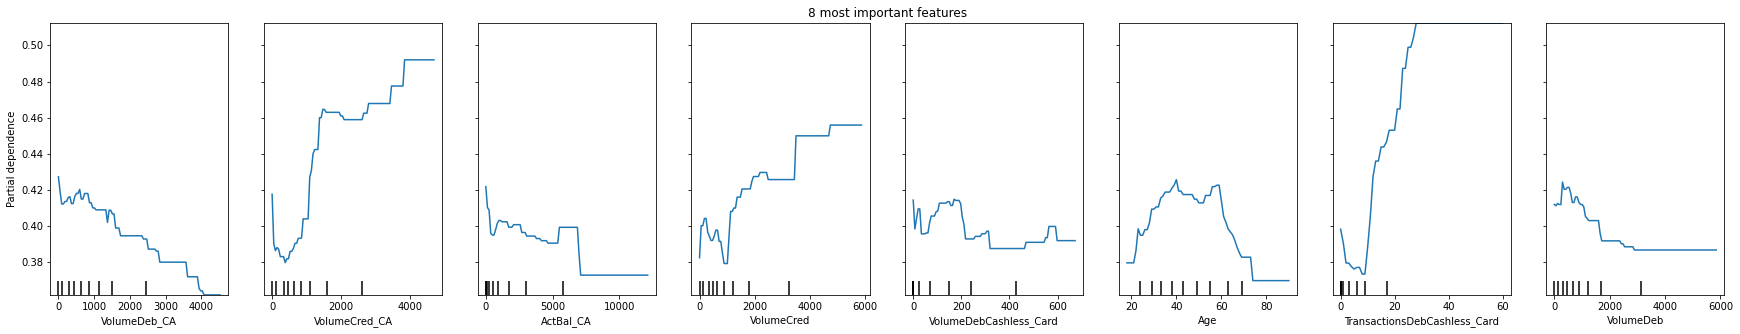

In [44]:
visualize_partial_dependence(m_Sale_MF, df_train_MF_X, feature_importance_Sale_MF)

**When predicting the propensity of sale of a mutual fund to a customer, the most important features identified were `VolumeDeb_CA`, `VolumeCred_CA`, `ActBal_CA`, `VolumeCred`, and `Age`.**

**Clients likely to purchase a mutual fund are between 30-60 years old who have a small debit turnover in their current accounts and a smaller current account balance. Instead, they tend to have a high credit turnover in their current accounts and in general as well.**

### 2.3.2 Mutual Fund Revenue

In [45]:
m_Revenue_MF = train_regression_model(df_train_MF_X, df_train_Revenue_MF_Y,
                                      n_estimators=100,
                                      criterion='mse',
                                      max_depth=12,
                                      min_samples_split=3,
                                      min_samples_leaf=2)

RMSE (Training set): 6.386
RMSE (Test set):     11.079



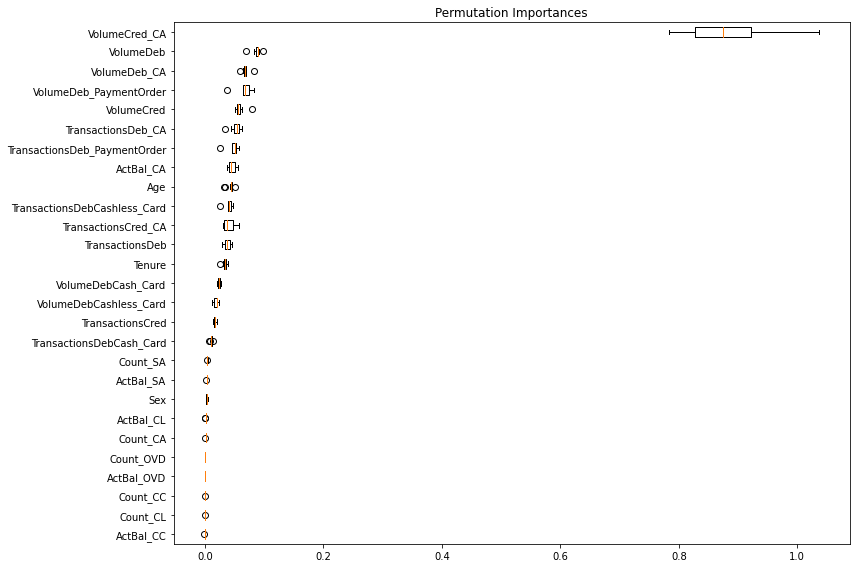

In [46]:
feature_importance_Revenue_MF = visualize_permutation_importance(m_Revenue_MF, df_train_MF_X, df_train_Revenue_MF_Y)

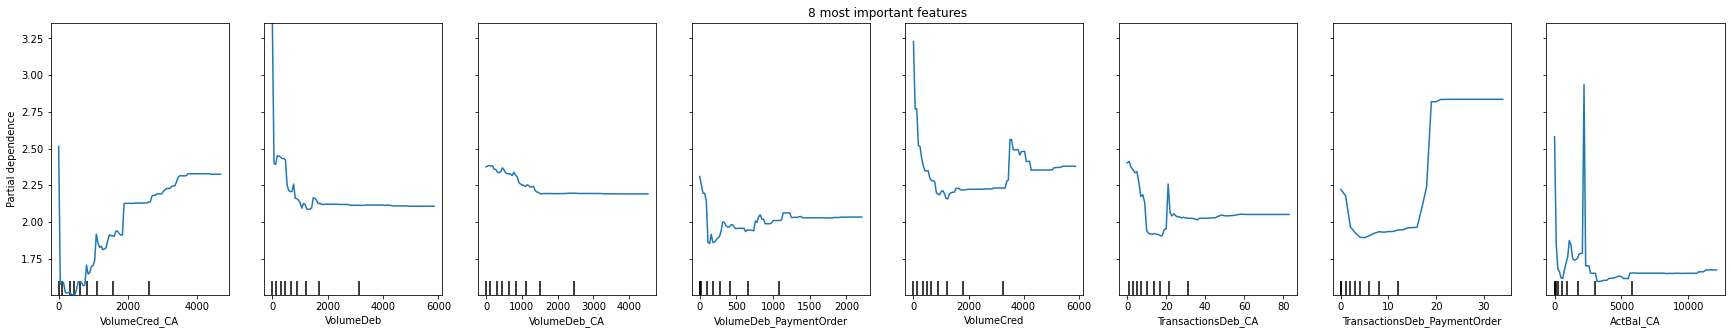

In [47]:
visualize_partial_dependence(m_Revenue_MF, df_train_MF_X, feature_importance_Revenue_MF)

**The key features of profitable clients of mutual funds identified were `VolumeCred_CA`, `VolumeDeb`, `VolumeDeb_CA`, `VolumeDeb_PaymentOrder`, and `VolumeCred`.**

**The model for profitable clients for mutual funds tend to be mostly affected by monthly turnover in clients' accounts. In particular, there seems to be a dependence between profit from a client having a mutual fund and making a smaller volume of debit transactions (in general, and in particular from their current accounts). In terms of volume of credit transactions, clients with a very small or conversely large volume of transactions are the most favourable for the bank.**

# 3. Client Targetting

The set of clients to be targeted by the bank's marketing is determined by the maximum expected revenue from the marketing campaign. The task is constrained by the bank's capacity to contact only 15% of the clients with a marketing offer and each client can be targeted only once.

The maximum expected revenue of a client is the highest revenue value computed as the product of the probability of client purchasing a service and the expected revenue from that client.

Top 15% (90) of clients with maximum expected revenue have been identified, alongside with what product they should be targeted with in a direct marketing campaing.

**Potential profitability of the solution could be increased by allowing to give targeted offers to customers that have purchased one of the three services (i.e. customers who are in the training set), but have not purchased at least one of the services.** For instance, if a customer already has a credit card but not a consumer loan, they could be included in the prediction dataset for sale/profitability of consumer loans as they are valid candidates. This is not the case right now, as the task description does not allow for it.

#### Compute consumer loan data predictions

In [48]:
# predict the probability of the client purchasing a consumer loan
predicted_Sale_CL = m_Sale_CL.predict_proba(df_guess[features_CL])[:,1]
# predict the revenue from the client with the consumer loan
predicted_Revenue_CL = m_Revenue_CL.predict(df_guess[features_CL])
# store in dataframe
df_guess = df_guess.assign(pred_Sale_CL=predicted_Sale_CL,
                           pred_Revenue_CL=predicted_Revenue_CL,
                           ExpectedRevenue_CL=predicted_Sale_CL * predicted_Revenue_CL)

#### Compute credit card data predictions

In [49]:
# predict the probability of the client purchasing a credit card
predicted_Sale_CC = m_Sale_CC.predict_proba(df_guess[features_CC])[:,1]
# predict the revenue from the client with the credit card
predicted_Revenue_CC = m_Revenue_CC.predict(df_guess[features_CC])
# store in dataframe
df_guess = df_guess.assign(pred_Sale_CC=predicted_Sale_CC,
                           pred_Revenue_CC=predicted_Revenue_CC,
                           ExpectedRevenue_CC=predicted_Sale_CC * predicted_Revenue_CC)

#### Compute mutual fund data predictions

In [50]:
# predict the probability of the client purchasing a mutual fund
predicted_Sale_MF = m_Sale_MF.predict_proba(df_guess[features_MF])[:,1]
# predict the revenue from the client with the mutual fund
predicted_Revenue_MF = m_Revenue_MF.predict(df_guess[features_MF])
# store in dataframe
df_guess = df_guess.assign(pred_Sale_MF=predicted_Sale_MF,
                           pred_Revenue_MF=predicted_Revenue_MF,
                           ExpectedRevenue_MF=predicted_Sale_MF * predicted_Revenue_MF)

### Compute overall results

In [51]:
# compute & store maximum expected revenue of a client and the source (service) of that value
df_guess = df_guess.assign(pred_Offer=df_guess[['ExpectedRevenue_CL', 'ExpectedRevenue_CC', 'ExpectedRevenue_MF']].idxmax(axis=1))
df_guess = df_guess.assign(pred_Revenue=df_guess[['ExpectedRevenue_CL', 'ExpectedRevenue_CC', 'ExpectedRevenue_MF']].max(axis=1))

In [52]:
# replace revenue source descripion string
df_guess.replace(regex=r'^ExpectedRevenue_', value='', inplace=True)
# get the clients to target by the marketing campaign
fifteen_perc = int(0.15 * df_guess.shape[0])
target_group = df_guess.sort_values(by='pred_Revenue', ascending=False)[['pred_Offer', 'pred_Revenue']].head(fifteen_perc)

For further research efforts, it might be useful to visualize how each model contributed into the total revenue.

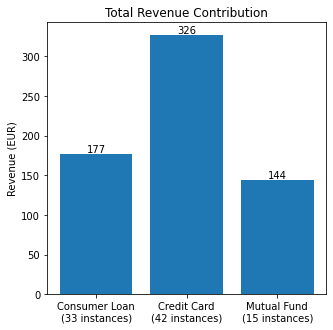

In [53]:
revenue_CL = sum(target_group[target_group['pred_Offer'] == 'CL']['pred_Revenue'])
n_CL_instances = target_group[target_group['pred_Offer'] == 'CL'].shape[0]
revenue_CC = sum(target_group[target_group['pred_Offer'] == 'CC']['pred_Revenue'])
n_CC_instances = target_group[target_group['pred_Offer'] == 'CC'].shape[0]
revenue_MF = sum(target_group[target_group['pred_Offer'] == 'MF']['pred_Revenue'])
n_MF_instances = target_group[target_group['pred_Offer'] == 'MF'].shape[0]

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title("Total Revenue Contribution")
bars = plt.bar(x=['Consumer Loan\n(%d instances)' % n_CL_instances, 'Credit Card\n(%d instances)' % n_CC_instances, 'Mutual Fund\n(%d instances)' % n_MF_instances],
               height=[revenue_CL, revenue_CC, revenue_MF])
for rect in bars:
    plt.text(rect.get_x() + rect.get_width()/2.0, rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom')

plt.ylabel("Revenue (EUR)")
plt.show()

We can see that credit card marketing contributes the most into the overall revenue of the campaign, more than the other two campaigns combined (given the constraints). That being said the mutual fund campaign yields the biggest profit per client targeted. **It might be valuable to examine mutual fund marketing efforts further in another project...**

# Executive Summary

The goal of this task is to identify suitable candidates for a direct marketing campaign while maximizing its potential revenue. This was achieved by developing machine learning models for estimating the propensity of a client to purchase either a consumer loan, a credit card, or a mutual fund, and the revenue from their purchase. The analysis was done over a dataset of 1615 clients, 60% of which were used to train the models and 40% were identified as potential candidates for the marketing campaign. The solution was developed using Python with the help of Pandas, NumPy, and scikit-learn libraries.

Prior to training the models, the dataset was examined for missing and/or corrupted values and modified accordingly. An exploratory data analysis was conducted, giving further insight into the dataset and used as a justification for assumptions made. Then, Random Forests machine learning models were built to encapsulate the non-linear relationships in the data. This allowed for explanation of dependencies among variables in the dataset that were used to interpret the model and its predictions.
 
In terms of consumer loans, clients likely to purchase are either very young clients of the bank, or retired clients that have been loyal customers. Their current and savings account balances are low, they have the tendency for small cashless transactions and have a high turnover on their current accounts. Profitable clients in many ways share this description too. However, they have more money in their current accounts and have a large volume of cashless card transactions.
 
For credit cards, clients identified as likely buyers are older clients of the bank with higher than average amount of money in their current account. They also often hold a savings account, with clients being more prone to purchase a card if their savings account balance is higher. In terms of revenue, clients with high amount of debit cash transactions via card that have been with the bank for a while have been identified as profitable. They are also more likely to have a smaller credit turnover on their current accounts, but a larger volume of debit cash transactions in general.
 
Clients with a high propensity to purchase a mutual fund are between 30-60 years old who have a small balance and a small debit turnover in their current accounts. Instead, they tend have a high credit turnover in their current accounts and in general as well. The model for profitable clients tends to be mostly affected by monthly turnover in clients' accounts. In particular, there seems to be a dependence between profit from a client having a mutual fund and making a smaller volume of debit transactions (in general, and in particular from their current accounts). In terms of volume of credit transactions, clients with a very small or conversely larger volume of transactions are the most favourable for the bank.
 
The models developed were able to improve the baseline substantially and offer valuable insight into the client dataset. 90 clients were identified as the most suitable clients for the direct marketing campaign, revenue of which was estimated to be 647.67 EUR.

In [54]:
with pd.option_context('display.max_rows', None):
    print(target_group.rename(columns={'pred_Offer': 'Offer','pred_Revenue': 'Revenue (EUR)'}))
    
print('Expected revenue of the strategy: %.2f EUR.' % sum(target_group.pred_Revenue))

       Offer  Revenue (EUR)
Client                     
766       MF      27.610478
596       MF      16.643523
401       CC      16.418626
110       MF      16.113928
331       CC      15.665231
516       CC      15.581234
1296      CC      14.610052
931       CC      14.585340
1365      CC      14.046142
1443      CC      13.836943
996       CC      13.588911
200       MF      13.563963
532       MF      13.021733
373       CC      12.840219
153       CC      11.106545
41        CL      10.739884
84        CC      10.610395
866       CC      10.530806
506       MF      10.400465
496       CC      10.294612
206       CC       8.617768
330       MF       8.571266
674       CL       8.519574
1119      CL       7.671397
389       CC       7.657399
1455      CC       7.204251
1373      CL       7.031235
1349      CC       6.984874
197       CC       6.964974
265       MF       6.788368
706       CC       6.586986
562       CL       6.569965
1077      CC       6.081744
454       CC       6